In [2]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import spacy

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, HashingVectorizer

from wordcloud import WordCloud

import collections
import math

%matplotlib inline 

import torch
import torch.nn as nn
from torchtext import data
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, LabelField

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab_Notebooks/7_eksamino/AI/'

traindf = pd.read_csv(path + 'vs_train.csv')
valdf = pd.read_csv(path + 'vs_dev.csv')


In [4]:
nlp = spacy.load("en_core_web_sm")

stopSet = {'.', ',', '-', '!', '$', '%', '^','&','*','(',')','_','+','=','\'','\"',':','—', '#', '@'}
traindf_list = []

def lemmatization(column):
  count=0
  lemmatized = []
  for x in column:
    spaced = nlp(x)
    lemmastr = ""
    for token in spaced:
      token.lemma_ = token.lemma_.lower()
      if token.is_stop == False and not token.lemma_ in stopSet:
        lemmastr += str(token.lemma_+' ')
    lemmatized.append(lemmastr)
    count+=1
    if(count >1000):
      count = 0
      print(count)
  return lemmatized


In [4]:
import urllib.request
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.twitter.27B.zip','glove.twitter.27B.zip')

!unzip "/content/glove.twitter.27B.zip" -d "/content/"

Archive:  /content/glove.twitter.27B.zip
  inflating: /content/glove.twitter.27B.25d.txt  
  inflating: /content/glove.twitter.27B.50d.txt  
  inflating: /content/glove.twitter.27B.100d.txt  
  inflating: /content/glove.twitter.27B.200d.txt  


In [5]:
emmbed_dict = {}
with open('/content/glove.twitter.27B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [7]:
train_list = lemmatization(traindf.tweet)
train = pd.DataFrame( list(zip(train_list, traindf.label)) , columns = ['tweet', 'label'])

test_list = lemmatization(valdf.tweet)
test = pd.DataFrame( list(zip(test_list, valdf.label)) , columns = ['tweet', 'label'])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [75]:
#split_perc = math.floor(0.9*train.shape[0])
#train_csv = train.iloc[:split_perc]
#valid_csv = train.iloc[split_perc:]
train.to_csv(path + 'train.csv', index=False)
test.to_csv(path + 'valid.csv', index=False)
#test.to_csv(path+ 'test.csv', index=False)


In [10]:

stopSet = {'.', ',', '-', '!', '$', '%', '^','&','*','(',')','_','+','=','\'','\"',':','—', '#', '@'}

text = Field(tokenize='spacy',batch_first=True,include_lengths=True, stop_words=stopSet)
label = LabelField(dtype = torch.float,batch_first=True, sequential=False)

fields = [('text',text), ('label', label)]

train_data = TabularDataset(path = str(path +'train.csv'),format = 'csv',fields = fields,skip_header = True)
valid_data = TabularDataset(path = str(path +'valid.csv'),format = 'csv',fields = fields,skip_header = True)
#test_data = TabularDataset(path = str(path +'test.csv'),format = 'csv',fields = fields,skip_header = True)

train_iter = BucketIterator(train_data, batch_size=32, sort_key=lambda x: len(x.text), sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_data, batch_size=32, sort_key=lambda x: len(x.text),sort=True, sort_within_batch=True)
#test_iter = BucketIterator(test_data, batch_size=32, sort_key=lambda x: len(x.text), sort=True, sort_within_batch=True)


In [11]:
text.build_vocab(train_data,min_freq=2,vectors = "glove.twitter.27B.200d")  
label.build_vocab(train_data)

In [12]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

# function to compute learning curve and plot
def learning_curves(x_train, y_train, x_test, y_test, title_input):
  
  plt.plot(x_train, y_train, label = 'Training loss', linestyle = '-', marker='o')
  plt.plot(x_test, y_test, label = 'Validation loss',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('loss', fontsize = 10)
  plt.xlabel('epoch', fontsize = 10)
  title = title_input
  plt.title(title, fontsize = 14, y = 1.03)
  plt.legend()
  plt.ylim(0,1)
  plt.yticks(np.arange(0.0,1.0, 0.1))

def plot_roc_curve(fpr, tpr, roc_auc):
  lw = 2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(3), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )
  plt.plot([0.5,1], [0.5,1], color="gray", linestyle='dashed')
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()


In [73]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

class attention(nn.Module):
  def __init__(self, hidden_size):
    super(attention, self).__init__()

    self.attn = nn.Linear(hidden_size*2 ,1)

    self.activ = nn.Tanh()
    self.sfmax = nn.Softmax()

  def forward(self, rnn_out):
    attn_out = self.attn(rnn_out)
    attn_out = self.activ(attn_out)
    return self.sfmax(attn_out)


#########################################
######   CLASSIFICATION FUNCTION   ######
class NeuralNet(nn.Module):
  def __init__(self, text , hidden_size=20, output_dim=3,nlayers=3, rnn_type = 'GRU', skip_con=True):
    super(NeuralNet, self).__init__()

    if skip_con == False:
      nlayers = 2
    else:
      nlayers = 5

    self.rnn_type = rnn_type
    self.skip_con = skip_con
    self.nlayers=nlayers
    self.attention_flag = False
    # create embeddings layer and freeze weights 
    #num_embeddings, embedding_dim = weights_matrix.size()
    #self.emb_layer = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=True)
    vocab_size = len(text.vocab)
    embedding_dim = len(text.vocab.vectors[0])
    self.emb_layer = nn.Embedding(vocab_size, embedding_dim) 
    #self.emb_layer.load_state_dict({'weight': weights_matrix})

    self.rnns = nn.ModuleList()
    for i in range(nlayers):
      in_size = embedding_dim if i == 0 else hidden_size
      self.rnns.append(eval('nn.' + rnn_type) (input_size=in_size, hidden_size=hidden_size, num_layers=1,bidirectional=True))

    self.linear = nn.Linear(hidden_size*2, output_dim)
    self.out_activ_fun = nn.Softmax(dim=1)

    self.dropout = nn.Dropout(0.5)

    
  def forward(self, x, x_length):
    embedded = self.emb_layer(x)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_length,batch_first=True,enforce_sorted=False)

    #out1, (hidden1,cell) = self.h1(packed_embedded)
    in_state = packed_embedded

    queue = []
    for i in range(self.nlayers):
      if self.rnn_type == 'GRU':
        output, hidden = self.rnns[i](in_state)
      elif self.rnn_type == 'LSTM':
        output, (hidden, cell) = self.rnns[i](in_state)

      if (self.skip_con == True) and (i % 2 == 0):
        if len(queue)!=0:
          cached_state = queue.pop(0)
          temp = hidden
          hidden = hidden + cached_state
          queue.append(hidden)
        queue.append(hidden)

      if i != 0:
        hidden = self.dropout(hidden)
      in_state = hidden

    #hidden = torch.cat(out1[:,len(out1)-1,:])
    #hidden1 = self.dropout(torch.cat((hidden1[-2,:,:], hidden1[-1,:,:]), dim=1))
    if self.attention_flag:
      attn = attention(in_state.shape[2])
      in_state = torch.cat((in_state[-2,:,:], in_state[-1,:,:]), dim=1)
      attn_layer = attn(in_state)
      in_state = attn_layer * in_state
    else:
      in_state = torch.cat((in_state[-2,:,:], in_state[-1,:,:]), dim=1)
    out = self.linear(in_state)
    return out


def nn_loop(model, loss_fun, optimizer, train_loader=train_iter, valid_loader=valid_iter, epochs=10):
  
  losses_train = []
  losses_valid = []
  patience = 2
  last_loss = 1000000
  ########### epoch loop ##########
  for epoch in range(epochs):

    ##############
    # training
    ##############
    model.train()
    losses = 0
    for ( (text, text_len),labels) in train_loader:
      output = model(text, text_len)
      # apply loss fun and get 
      loss = loss_fun(output, labels.type(torch.long))
      losses += loss.item()
      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #clip params
      for param in model.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -2, 2)
      #Update net's weights based on the gradients calculated during backprop
      optimizer.step()

    # save loss for train in this epoch
    losses_train += [ losses / len(train_loader)]

    ############
    # evaluation
    ############
    model.eval()
    losses=0
    y_label_valid = []
    y_pred_valid = []
    with torch.no_grad():
      for((text, text_len),labels) in valid_loader:

        output = model(text, text_len)
        loss = loss_fun(output, labels.type(torch.long))
        y_pred_softmax = model.out_activ_fun(output)
        losses += loss.item()
        #if epoch == (epochs-1):
        y_label_valid += labels.tolist()
        y_pred_valid += y_pred_softmax.tolist()

    # save loss for valid in this epoch
    losses_valid += [losses / len(valid_loader)]

    # implement early stopping, if validation loss is rising 'patience' times in a row
    if losses > last_loss:
      trigger_times += 1
      if trigger_times >= patience:
        break
    else:
      trigger_times = 0

    last_loss = losses


  y_pred_arr = np.array([np.array(xi) for xi in y_pred_valid])
  y_test_arr = np.array(y_label_valid).astype(int)
  y_test_roc = np.zeros((y_test_arr.size, np.max(y_test_arr)+1))
  y_test_roc[np.arange(y_test_arr.size),y_test_arr] = 1

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = y_pred_arr.shape[1]
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_arr[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  y_pred = [x.index(max(x)) for x in y_pred_valid]
  y_label = y_label_valid

  return losses_train, losses_valid, y_pred, y_label, fpr, tpr, roc_auc, epoch+1

  



def classify(train_iter,valid_iter, rnn_type='LSTM', skip_cons=False):
  plt.figure(figsize = (14,7))

  #Define layer sizes
  dim_out = 3

  #Define Hyperparameters
  #learning_rate = 9e-2   # lr for SGD
  learning_rate = 1e-4    # lr for Adam

  #Initialize net, loss, optimizer
  model = NeuralNet(text,rnn_type=rnn_type, skip_con=skip_cons)
  # initialize weights
  pretrained_embeddings = text.vocab.vectors
  model.emb_layer.weight.data.copy_(pretrained_embeddings)
  model.emb_layer.weight.requires_grad = False
  #weights = torch.tensor([0.5,1.0,0.5])  # weights for SGD

  loss_fun = nn.CrossEntropyLoss()
  #loss_fun = nn.BCELoss()
  #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  epochs = 20
  train_losses, test_batch_losses, y_pred, y_label, fpr, tpr, roc_auc, iters = nn_loop(model, loss_fun, optimizer, train_iter, valid_iter, epochs)

  x_axis = [i for i in range(iters)]

  plt.subplot(1,2,1)
  title = "loss vs epoch"
  learning_curves(x_axis, train_losses, x_axis, test_batch_losses, title)

  plt.subplot(1,2,2)
  plot_roc_curve(fpr,tpr,roc_auc)
  counter = [(x==1) for x in y_label]
  print(sum(counter))
  print(classification_report(y_label, y_pred, target_names=['Neutral', 'Anti-Vax', 'Pro-Vax']))



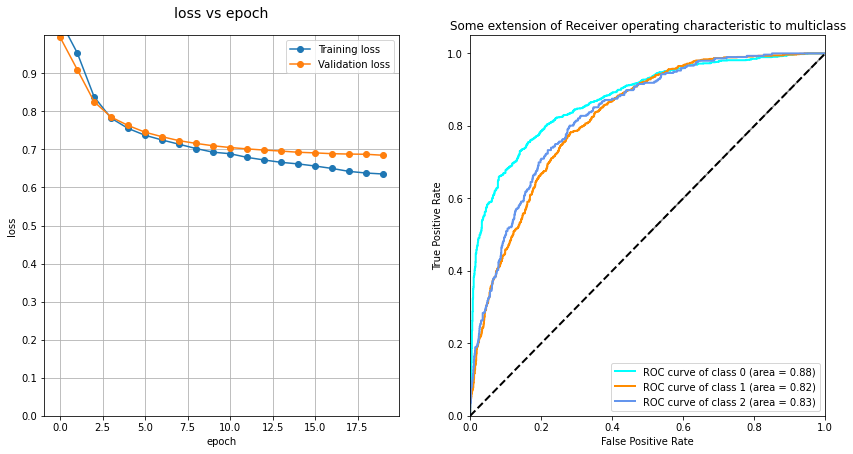

921
              precision    recall  f1-score   support

     Neutral       0.79      0.77      0.78      1065
    Anti-Vax       0.66      0.76      0.70       921
     Pro-Vax       0.51      0.29      0.37       296

    accuracy                           0.70      2282
   macro avg       0.65      0.61      0.62      2282
weighted avg       0.70      0.70      0.70      2282



In [74]:
classify(train_iter, valid_iter,'LSTM', skip_cons=False)

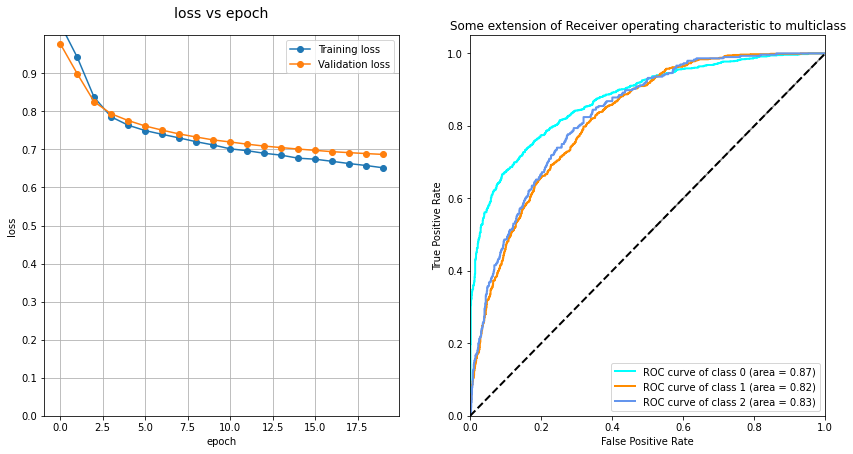

921
              precision    recall  f1-score   support

     Neutral       0.79      0.75      0.77      1065
    Anti-Vax       0.63      0.75      0.69       921
     Pro-Vax       0.47      0.28      0.35       296

    accuracy                           0.69      2282
   macro avg       0.63      0.59      0.60      2282
weighted avg       0.68      0.69      0.68      2282



In [55]:
classify(train_iter, valid_iter,'GRU', skip_cons=False)

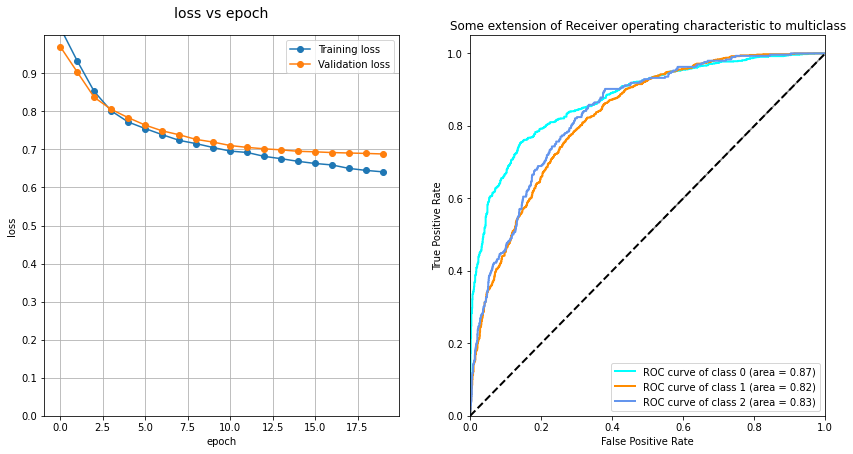

921
              precision    recall  f1-score   support

     Neutral       0.79      0.78      0.79      1065
    Anti-Vax       0.66      0.74      0.70       921
     Pro-Vax       0.50      0.35      0.41       296

    accuracy                           0.71      2282
   macro avg       0.65      0.62      0.63      2282
weighted avg       0.70      0.71      0.70      2282



In [53]:
classify(train_iter, valid_iter,'LSTM', skip_cons=True)

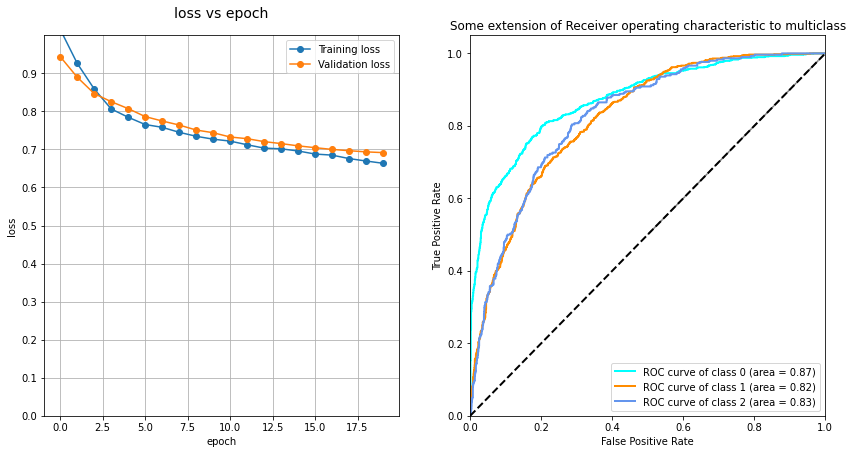

921
              precision    recall  f1-score   support

     Neutral       0.78      0.77      0.78      1065
    Anti-Vax       0.65      0.74      0.69       921
     Pro-Vax       0.47      0.31      0.37       296

    accuracy                           0.70      2282
   macro avg       0.64      0.60      0.61      2282
weighted avg       0.69      0.70      0.69      2282



In [54]:
classify(train_iter, valid_iter,'GRU', skip_cons=True)